# Preparation

## Imports

In [255]:
# packages
import matplotlib.pyplot as plt
import numpy as np
import sys

import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# PyTorch
import torch.optim
from torch import nn
from torchvision import transforms
import torch
import torchvision.transforms.functional as tf

# Dataset to train and test
from torchvision.datasets import MNIST
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output
from PIL import Image

In [27]:
from IPython.core.ultratb import VerboseTB
VerboseTB._tb_highlight = "bg:#e68cc3"

if "dracula" in plt.style.available:
    plt.style.use("dracula")

## Devices

In [25]:
cpu_device = torch.device("cpu")

# Windows with NVidia GPU
if torch.cuda.is_available():
    gpu_device = torch.device("cuda")

# Mac with Apple Silicon
if torch.has_mps:
    gpu_device = torch.device("mps")

## Download data

In [722]:
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [723]:
for x, y in train_dataset:
    print(x.std())
    break

tensor(1.0144)


## Preview

torch.FloatTensor


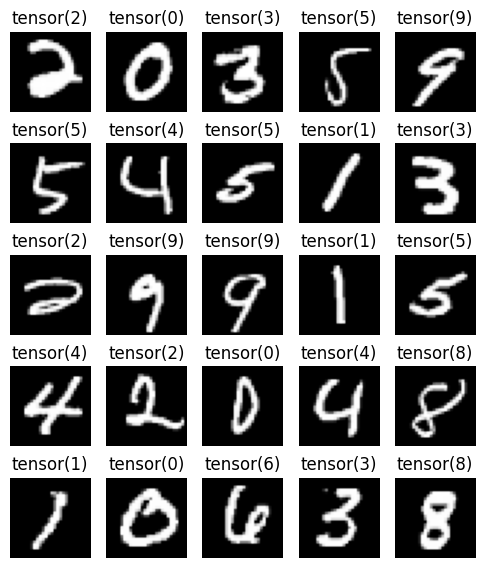

In [111]:
plt.figure(figsize=(6, 7))
for X, y in train_loader:
    print(X[0].type())
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(y[i])
        plt.axis('off')
    break

# Train function

In [45]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None, gpu=False):
    loss = loss or nn.NLLLoss()
    optimizer = torch.optim.Adam(params=network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    if gpu:
        network.to(device=gpu_device)
    else:
        network.to(device=cpu_device)
    for epoch in tqdm(range(epochs)):
        network.train()
        losses = []
        accuracies = []
        for X, y in train_loader:
            network.zero_grad()
            if gpu:
                X = X.to(device=gpu_device)
                y = y.to(device=gpu_device)
            prediction = network(X)
            loss_batch = loss(prediction, y)
            losses.append(loss_batch.item())
            loss_batch.backward()
            optimizer.step()
            accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1) == y.data.cpu().numpy()).mean())
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))
        losses = []
        accuracies = []
        network.eval()
        with torch.no_grad():
            for X, y in test_loader:
                if gpu:
                    X = X.to(device=gpu_device)
                    y = y.to(device=gpu_device)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1) == y.data.cpu().numpy()).mean())
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))
        clear_output(True)
        if verbose:
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()
    return train_loss_epochs, \
        test_loss_epochs, \
        train_accuracy_epochs, \
        test_accuracy_epochs

# Network

In [36]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, (3, 3), padding=1),
            nn.ReLU()
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(3136, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [38]:
conv_classifier = ConvClassifier()

In [46]:
tr_s, ts_s, tr_ac, ts_ac = train(conv_classifier, 20, 0.01, plot=False, verbose=False, loss=nn.CrossEntropyLoss(), gpu=False)

100%|██████████| 20/20 [05:44<00:00, 17.21s/it]


In [49]:
tr_s, ts_s, tr_ac, ts_ac = train(conv_classifier, 20, 0.01, plot=False, verbose=False, loss=nn.CrossEntropyLoss(), gpu=True)

100%|██████████| 20/20 [04:41<00:00, 14.08s/it]


In [50]:
conv_classifier.eval()

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3136, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

# Let's examine incorrect predicitons

In [57]:
pictures = []
nums = []
for X, y in test_loader:
    output = conv_classifier(X.to(device=gpu_device))
    output = output.argmax(axis=1)
    for i in range(X.shape[0]):
        if output[i] != y[i]:
            pictures.append(X[i])
            nums.append(f"({(output[i])})/{y[i]}")

In [66]:
pictures[0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

C:\Users\cryst\AppData\Local\Temp\ipykernel_10444\946465135.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=2)
C:\Users\cryst\AppData\Local\Temp\ipykernel_10444\946465135.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i+1)


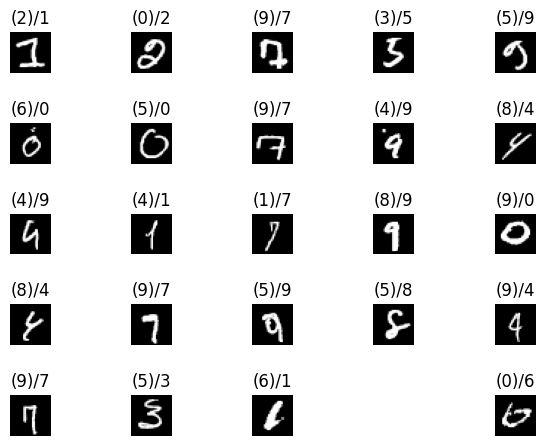

In [63]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(pictures[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(nums[i])
    plt.tight_layout(h_pad=2)
    plt.axis("off")

# Evaluate network

In [86]:
for X, _ in train_loader:
    min_v = X[0].min()
    max_v = X[0].max()
    break

In [87]:
scaler = MinMaxScaler(feature_range=(float(min_v), float(max_v)))

In [89]:
min_v

tensor(-0.4242)

In [158]:
dataset = datasets.ImageFolder("./test_dataset/", transform=transform)

validate_loader = DataLoader(dataset, batch_size=1, shuffle=False)

C:\Users\cryst\AppData\Local\Temp\ipykernel_10444\3652399926.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


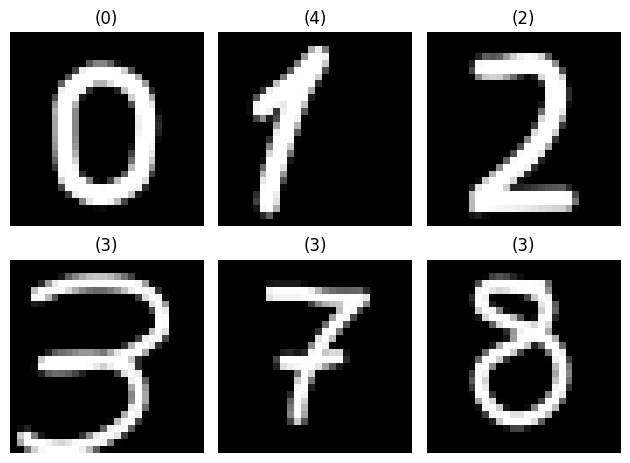

In [194]:
preds = []
for i, (X, y) in enumerate(validate_loader):
    pred = conv_classifier(X)
    preds.append(pred)
    pred = np.argmax(pred.detach().numpy(), axis=1)[0]
    plt.subplot(2, 3, i+1)
    plt.imshow(X.reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.tight_layout()
    plt.title(f"({pred})")

In [197]:
for i in range(len(preds[5][0])):
    print(preds[5][0][i])

tensor(-194.7500, grad_fn=<SelectBackward0>)
tensor(-305.2141, grad_fn=<SelectBackward0>)
tensor(-74.3859, grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<SelectBackward0>)
tensor(-356.5659, grad_fn=<SelectBackward0>)
tensor(-90.4666, grad_fn=<SelectBackward0>)
tensor(-191.8167, grad_fn=<SelectBackward0>)
tensor(-470.8969, grad_fn=<SelectBackward0>)
tensor(-49.0977, grad_fn=<SelectBackward0>)
tensor(-245.5579, grad_fn=<SelectBackward0>)


# Kaggle competition

## Network

In [619]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 24, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, (5, 5)),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(768, 10),
            nn.Softmax()
        )

    def forward(self, input):
        output = self.layers(input)

        return output

## Preparing Dataset

In [620]:
label_transforms = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x).to(torch.long)),
])

In [688]:
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    # transforms.Lambda(lambda x: x[i][j] / 255 for i in range(28) for j in range(28))
    transforms.Normalize((0.1307,), (0.3081,))
])

In [725]:
df = pd.read_csv("train.csv")

In [727]:
df.apply(lambda x: x / 255)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.015686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,0.027451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,0.023529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [728]:
class MnistDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None, train=False):
        df = pd.read_csv(annotations_file)
        # self.img_pixels = df.loc[:, df.columns!="label"].values
        self.img_pixels = df.loc[:, df.columns!="label"].apply(lambda x: x / 255).values.reshape(df.__len__(), 28, 28)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.img_labels = df["label"].astype("long").values if self.train else None

    def __len__(self):
        return len(self.img_pixels)

    def __getitem__(self, idx):
        image = self.img_pixels[idx]
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.img_labels[idx]
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else:
            return image

In [729]:
mnist_train_dataset = MnistDataset("train.csv", transform=img_transforms, target_transform=label_transforms, train=True)
mnist_test_dataset = MnistDataset("test.csv", transform=img_transforms, train=False)

In [730]:
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=32, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=32, shuffle=False)

C:\Users\cryst\AppData\Local\Temp\ipykernel_10444\2645947673.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\cryst\AppData\Local\Temp\ipykernel_10444\2645947673.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i+1)


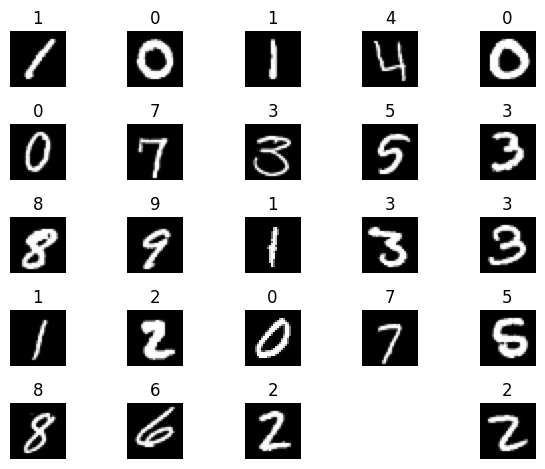

In [735]:
for X, y in mnist_train_loader:
    # print(X.max())
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i][0], cmap=plt.cm.Greys_r)
        plt.axis("off")
        plt.title(y[i].item())
        plt.tight_layout()
    break

## Function for training

In [736]:
def train_kaggle(network: nn.Module, dataset: DataLoader, loss = None, optim: torch.optim = None,
                 learning_rate: float = 0.01, epochs: int =10, gpu: bool = False,
                 plot: bool = False, verbose: bool = False):
    loss = loss or nn.NLLLoss()
    optim = optim or torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []

    train_preds = []

    network.to(device=gpu_device) if gpu else network.to(device=cpu_device)

    network.train()
    for i in tqdm(range(epochs)):
        accuracies = []
        losses = []
        preds = []
        for X, y in dataset:
            if gpu:
                X = X.to(device=gpu_device)
                y = y.to(device=gpu_device)

            pred = network(X)
            batch_loss = loss(pred, y)
            losses.append(batch_loss.item())
            batch_loss.backward()
            optim.step()

            accuracies.append((np.argmax(pred.detach().cpu().data.numpy(), axis=1) == y.cpu().data.numpy()).mean())
            preds.append(pred)
        train_losses.append(np.mean(losses))
        train_accuracies.append(np.mean(accuracies))
        train_preds.append(preds)
        clear_output(True)
        if verbose:
            sys.stdout.write(f"Epoch {i}: Train loss/accuracy: {train_losses[i]:.3f}/{train_accuracies[i]:.3f}")
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.xlabel("Epoch")
            plt.ylabel("Losses")
            plt.plot(train_losses)
            plt.grid("on")
            plt.subplot(1, 2, 2)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot(train_accuracies)
            plt.grid("on")
            plt.show()
    return train_accuracies, train_losses, train_preds

In [739]:
cnn = ConvClassifier()

In [627]:
tr_ac, tr_ls = train_kaggle(conv_cls, mnist_train_loader, loss=nn.CrossEntropyLoss(), gpu=False, verbose=True, plot=True)

  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

Epoch 4: Train loss/accuracy: 3.660/0.099

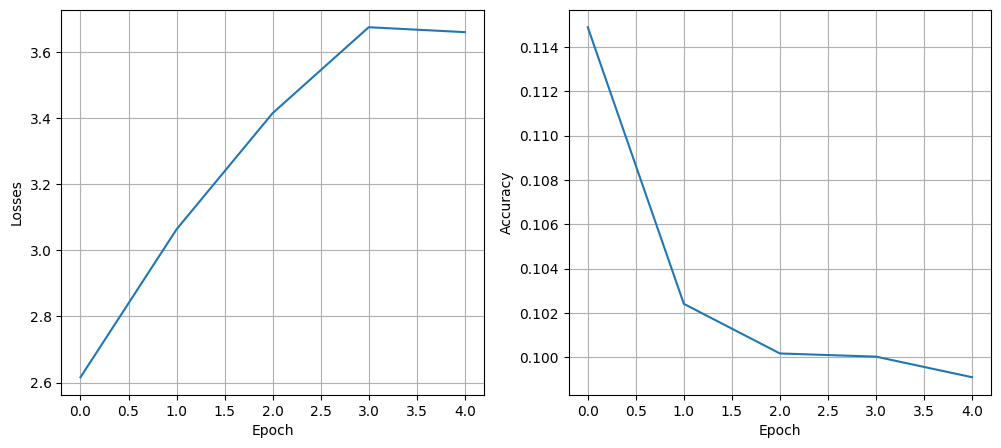

100%|██████████| 5/5 [00:44<00:00,  8.89s/it]


In [740]:
tr_ac, tr_ls, preds = train_kaggle(cnn, mnist_train_loader, epochs=5, loss=nn.CrossEntropyLoss(), gpu=True, verbose=True, plot=True)

In [618]:
preds[4][0]

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],


## First prediction

In [741]:
def test_kaggle(network: nn.Module, dataset: DataLoader, gpu: bool = False):
    network.to(device=gpu_device) if gpu else network.to(device=cpu_device)

    network.eval()

    predictions = []

    with torch.no_grad():
        for X in tqdm(dataset):
            if gpu:
                X = X.to(device=gpu_device)
            preds = network(X)

            predictions.append(preds)

    return predictions

In [743]:
preds = test_kaggle(cnn, mnist_test_loader, gpu=True)

100%|██████████| 875/875 [00:03<00:00, 262.23it/s]


C:\Users\cryst\AppData\Local\Temp\ipykernel_10444\1149277152.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\cryst\AppData\Local\Temp\ipykernel_10444\1149277152.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i+1)


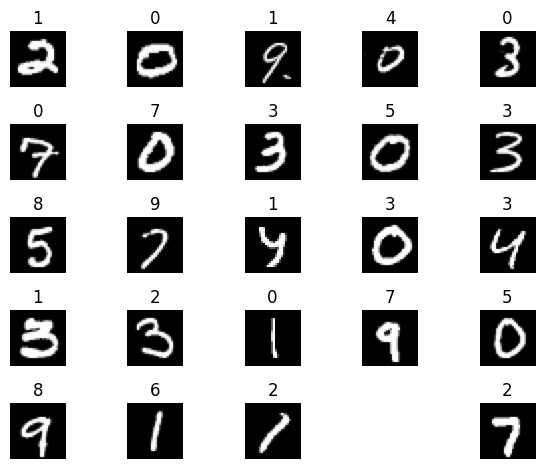

In [745]:
for X in mnist_test_loader:
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i][0], cmap=plt.cm.Greys_r)
        plt.axis("off")
        plt.title(y[i].item())
        plt.tight_layout()
    break

In [751]:
submission = []
i = 1
for pred_batch in preds:
    for probs in pred_batch:
        submission.append([i, probs.argmax().item()])
        i += 1


In [747]:
preds[5]

tensor([[-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -3.5815, -1.1851, -6.2709, -6.0854, -2.7450, -1.0180, -1.5048,
         -9.1263, -4.5117],
        [-5.6334, -

In [752]:
result = pd.DataFrame(submission, columns=["ImageID", "Label"])

In [753]:
result["Label"].value_counts()

Label
6    28000
Name: count, dtype: int64

In [754]:
result.to_csv("submission.csv", index=False)